# Fly counter prototyping

I thought I a protocol for counting flies in an image of a fly pad.  
- Threshold the image
- Use DBScan clustering to find clusters (these should be flies)
- Measure the area of the clusters
- Adjust thresholding until the clusters are as close to the same size as possible, since the flies should be mostly the same size.

### Import the image, turn into something that could be thresholded

In [65]:
import numpy as np
# from tensorflow.keras.preprocessing import image
from PIL import Image
from sklearn.cluster import DBSCAN, KMeans
from shapely.geometry import MultiPoint
from statistics import median
import math
color_array = ['#9e0142','#5e4fa2','#d53e4f',
               '#3288bd','#f46d43','#66c2a5',
               '#fdae61','#fee08b','#ffffbf',
               '#e6f598','#abdda4']

color_array = [
    "#2d0007",
    "#b6ff78",
    "#9800d2",
    "#1bbd4e",
    "#ff49ff",
    "#00ffff",
    "#a8002d",
    "#00beff",
    "#ffbe79",
    "#299fff",
    "#154323",
    "#fcc6ff",
    "#489677",
    "#4a77bd",
    "#8da08a"
]

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(color_array)
%matplotlib inline

In [5]:
## one option for image processing from datascience lecture 26 NeuralNets2
img_path = 'test_images/IMG_clip_20181219_130926.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# preds = vgg_model.predict(x)
# print('Predicted:', vgg16.decode_predictions(preds, top=5)[0])
# x
# img

NameError: name 'image' is not defined

In [6]:
# here are some options from https://www.codementor.io/isaib.cicourel/image-manipulation-in-python-du1089j1u
def open_image(path):
    newImg = Image.open(path)
    return newImg

def save_image(image, path):
    image.save(path, 'png')
    
def create_image(i, j):
    image = Image.new("RGB", (i, j), "white")
    return image

def get_pixel(image, i, j):
    
    # is in bound?
    width, height = image.size
    if i > width or j > height:
        return None
    
    # if ok, return pixel
    pixel = image.getpixel((i, j))
    return pixel


def convert_grayscale(image):
    # get the size
    width, height = image.size
    
    # create the new image and the pixel iter
    new = create_image(width, height)
    pixels = new.load()
    
    for i in range(width):
        for j in range(height):
            # get the pixel
            pixel = get_pixel(image, i, j)
            #get the RGB values
            red = pixel[0]
            green = pixel[1]
            blue = pixel[2]
            
            # trasform to greyscale
            gray = (red * 0.299) + (green * 0.587) + (blue * 0.114)
#             gray = (red + green + blue) / 3
            
            # set the pixel
            pixels[i, j] = (int(gray), int(gray), int(gray))
    
    return new

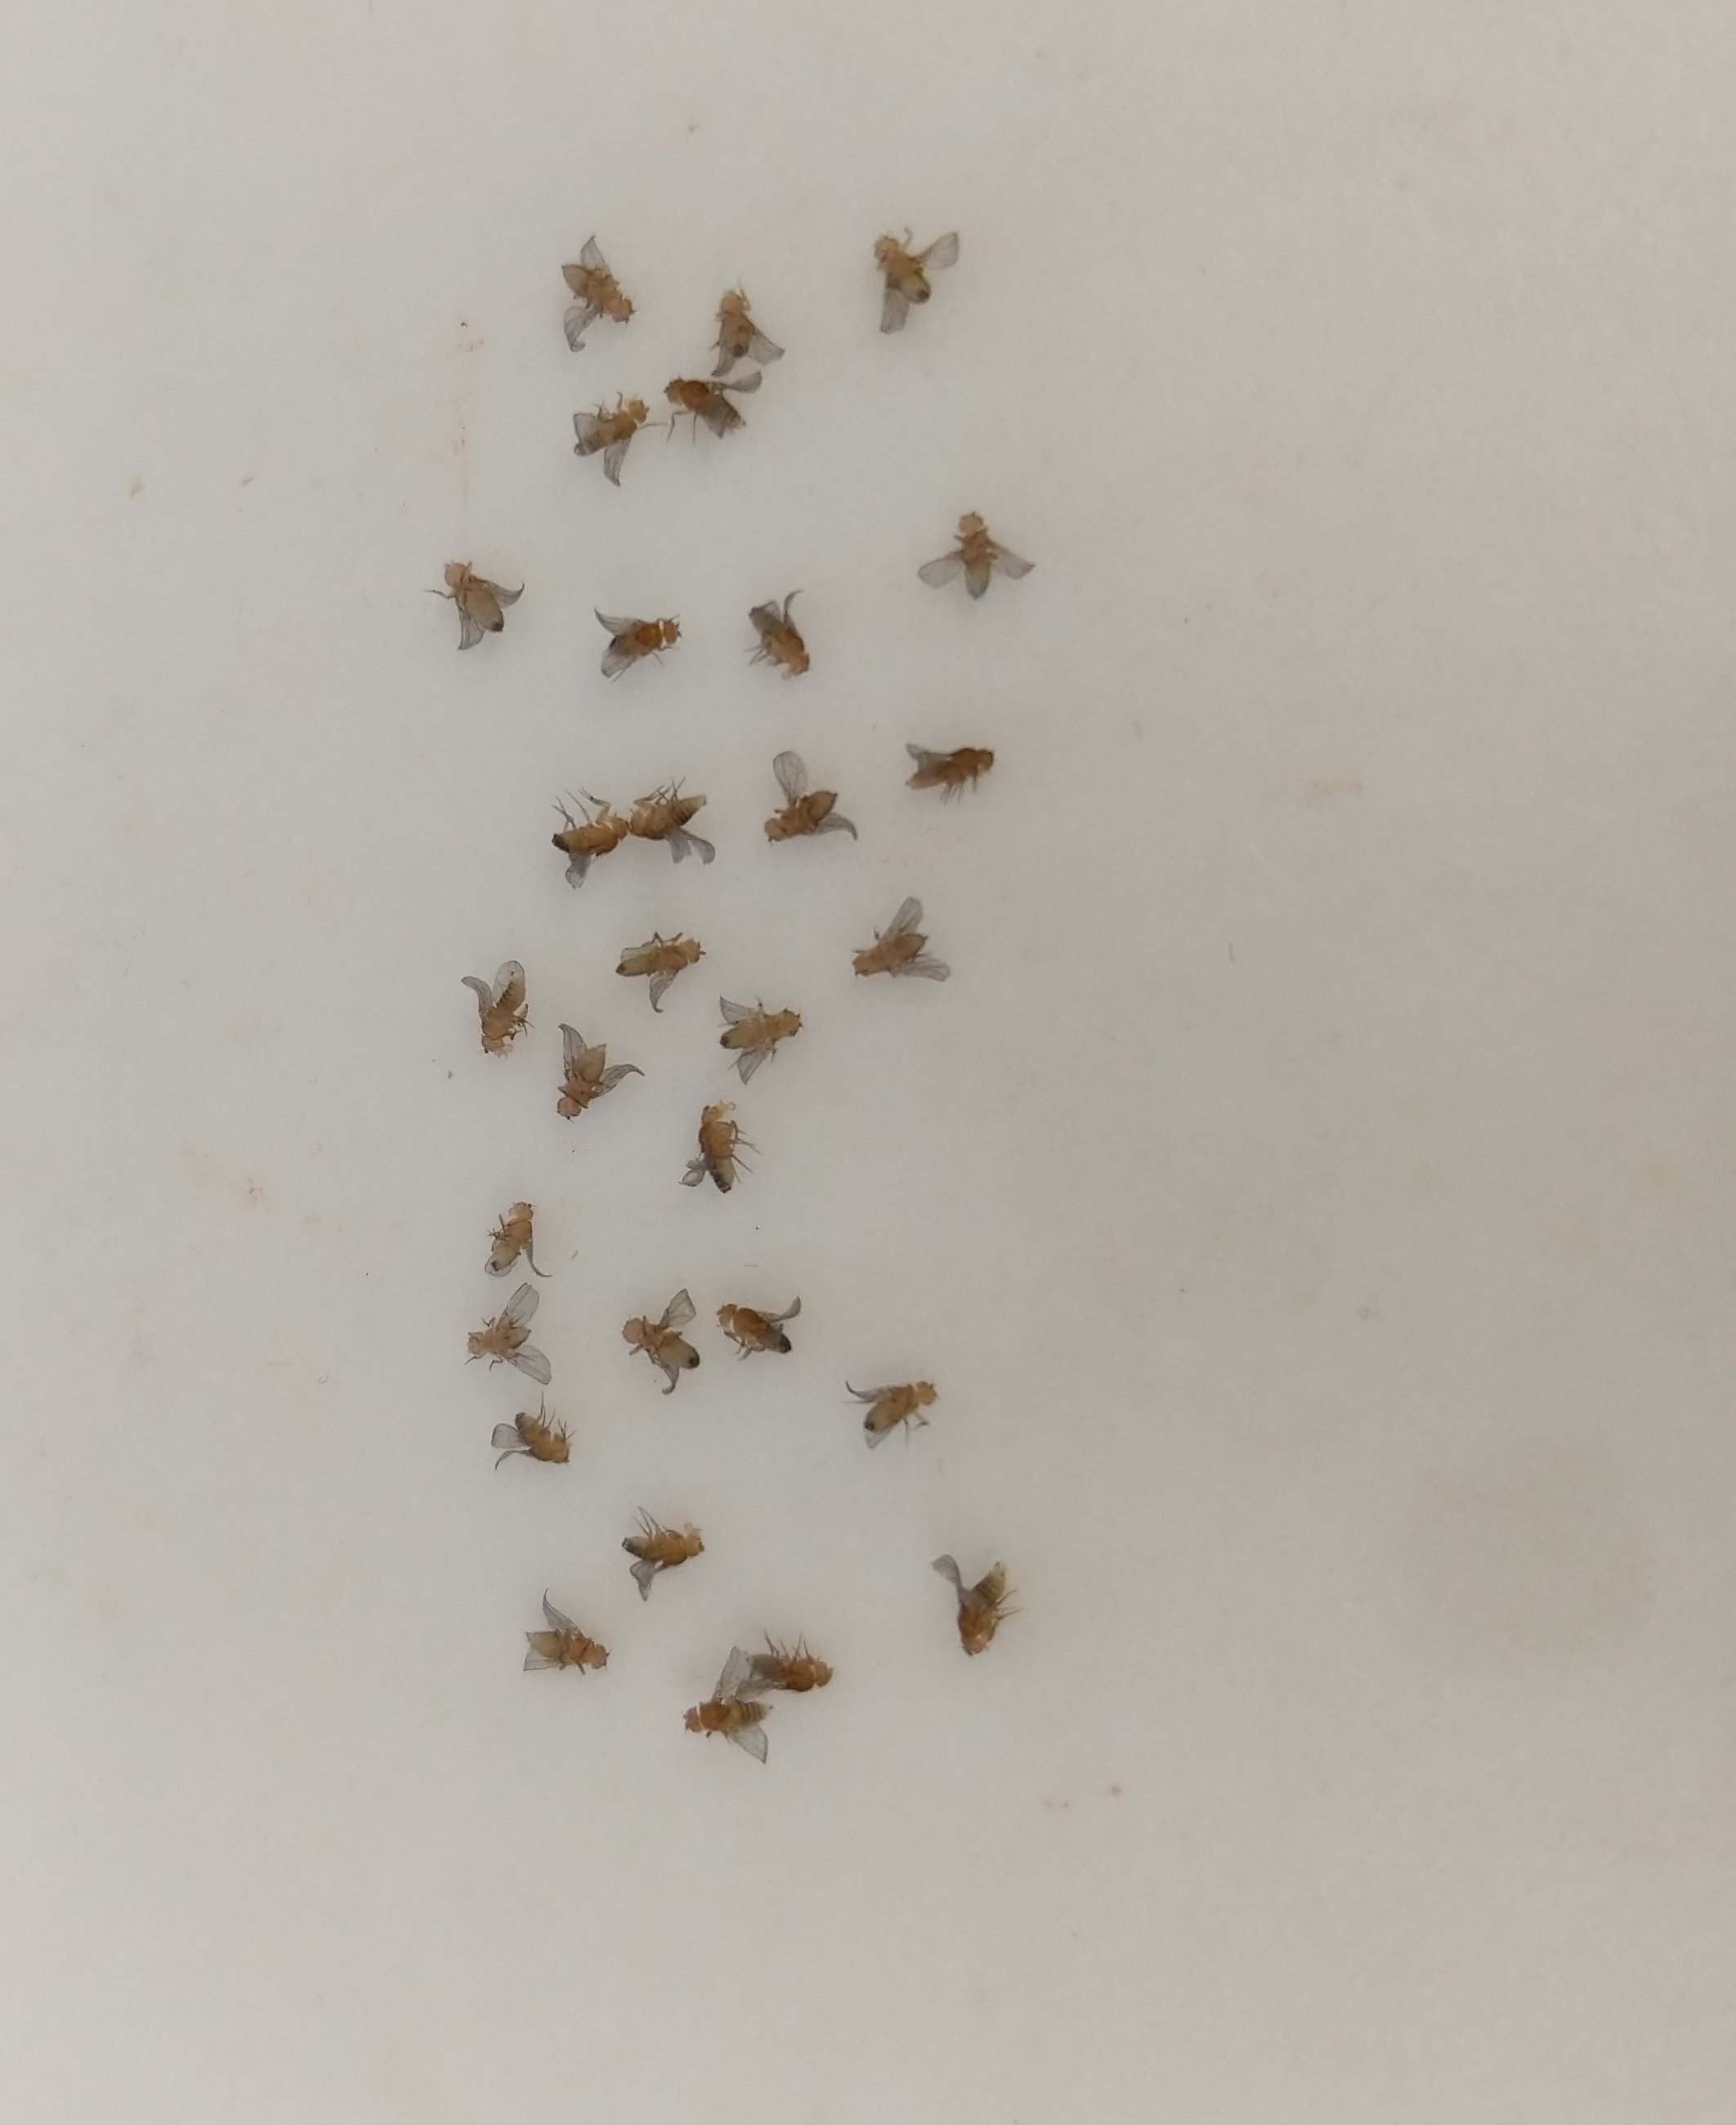

In [7]:
first_img = open_image(img_path)
first_img

One problem here is that the image is WAY too high quality - we don't need it to be 4032 x 3024.

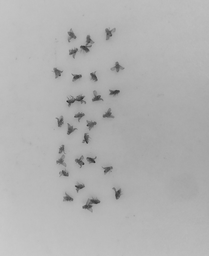

In [8]:
size = 256, 256
# this rescales in place!
first_img.thumbnail(size, Image.ANTIALIAS)
gray_img = convert_grayscale(first_img)
gray_img

That was so much faster, perfect.

In [9]:
def threshold_grascale_image(image, threshold):
    """Thresholds a grayscale image based on provided value"""
    
    # get the size
    width, height = image.size
    
    # create the new image and the pixel iter
    new = create_image(width, height)
    pixels = new.load()
    
    for i in range(width):
        for j in range(height):
            # get the pixel
            pixel = get_pixel(image, i, j)
            
            #get the pixel value. there are 3 of these, we only need 1
            gray = pixel[0]
            
            # keep if above the value, discard if below
            # black = 0, white is 255
            # if something is not infomative, I want it to be 0.
            # This is because of how I am going to quantify the image
            # later - drop 0's keep the best values
            if gray > threshold:
                gray = 0
            else:
                gray = 255

            # set the pixel
            pixels[i, j] = (int(gray), int(gray), int(gray))
    
    return new

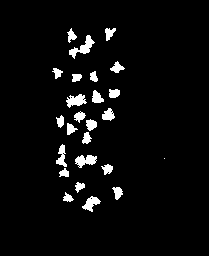

In [10]:
img = threshold_grascale_image(gray_img, 160)
img

Awesome! Thresholding works well. So now, we need to build an numpy array based on the position of the points.

In [11]:
def image_array(image):
    """
    Scans over a thresholded image, 
    gathers the points that have a value,
    Returns an np array of the points as coordinates
    """
    
    # get the size
    width, height = image.size
        
    x = []
    y = []
    for i in range(width):
        for j in range(height):
            # get the pixel
            pixel = get_pixel(image, i, j)
            
            #get the pixel value. there are 3 of these, we only need 1
            gray = int(pixel[0])
            
            ## save positions that have values
            if gray:
                x.append(i)
                y.append(-j)
    X = np.array(list(zip(x, y)))
    return X

In [12]:
X = image_array(img)
X

array([[  52,  -71],
       [  53,  -68],
       [  53,  -69],
       ...,
       [ 123,  -69],
       [ 124,  -68],
       [ 164, -158]])

## DBScan
This is a small block, but it is the code for DBScanning. It's important to remember that the image here is the results of the thresholding and the eps, which are what I am going to optimize in the next step.

Cluster number: 27


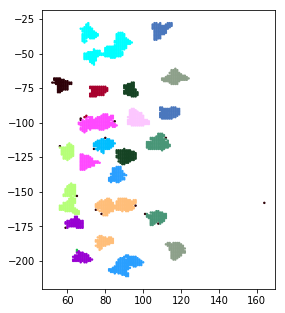

In [13]:
eps = 1
min_samples = 4

db_model = DBSCAN(eps=eps, min_samples=min_samples)
db_model.fit(X)
y_pred = db_model.fit_predict(X)
print("Cluster number: {}".format(len(set(y_pred))))

w,h = img.size
plt.rcParams['figure.figsize'] = (w/50, h/50)
plt.scatter(X[:, 0], X[:, 1], s=2, c=y_pred,  marker="o", cmap=cmap); 
# plt.ylim(90,100)
# plt.xlim(130, 140)
# plt.legend()
plt.show()

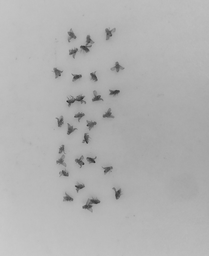

In [14]:
gray_img

In [15]:
x = np.arange(0,1,0.001)
y = np.sqrt(1-x**2)
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
print(PolyArea(x,y))
%timeit PolyArea(x,y)

0.26353377782166376
40.3 µs ± 715 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


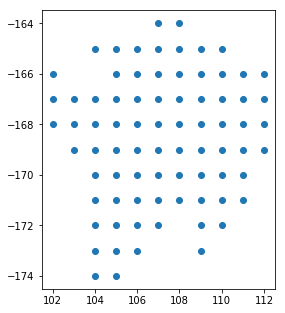

In [16]:
newX = []
newY = []
for idx, pred in enumerate(y_pred):
    if pred == 21:
        newX.append(X[idx][0])
        newY.append(X[idx][1])

plt.scatter(newX, newY)

In [17]:
pts = MultiPoint(list(zip(newX,newY)))
poly = pts.convex_hull
float(poly.area)

75.5

[6229.0, 62.0, 60.0, 151.0, 56.5, 54.5, 0.0, 184.0, 76.5, 68.5, 307.5, 0.5, 55.5, 74.0, 194.5, 63.0, 73.0, 166.5, 85.0, 54.5, 95.5, 105.5, 75.5, 83.0, 73.5, 91.0, 83.5]


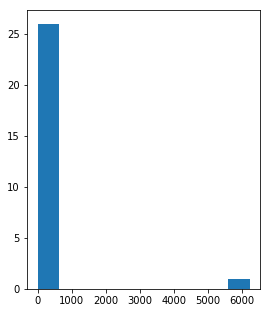

In [18]:
blobs = {}
for idx, pred in enumerate(y_pred):
    if pred not in blobs:
        blobs[pred] = []
    point = (X[idx][0], X[idx][1])
    blobs[pred].append(point)

areas = {}  
area_list = []
for blob in blobs:
    pts = MultiPoint(blobs[blob])
    poly = pts.convex_hull
    areas[blob] = float(poly.area)
    area_list.append(poly.area)

print(area_list)    
plt.hist(area_list)
plt.show()

In [19]:
median(area_list)

75.5

[62.0, 60.0, 151.0, 56.5, 54.5, 184.0, 76.5, 68.5, 307.5, 55.5, 74.0, 194.5, 63.0, 73.0, 166.5, 85.0, 54.5, 95.5, 105.5, 75.5, 83.0, 73.5, 91.0, 83.5]


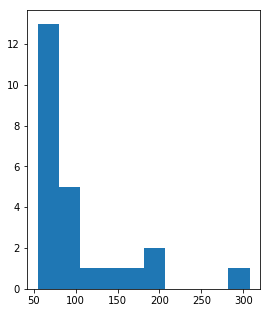

In [20]:
del_list = []
for blob in areas:
    if areas[blob] > (median(area_list) * 10):
        del_list.append(blob)
    if areas[blob] < (median(area_list) / 4):
        del_list.append(blob)
for del_it in del_list:
    del areas[del_it]

area_list = [areas[x] for x in areas]

print(area_list) 
plt.hist(area_list)
plt.show()

81.5
24
[65, 67, 130, 61, 60, 168, 74, 77, 216, 65, 79, 177, 65, 76, 149, 94, 62, 104, 108, 78, 86, 84, 90, 88]


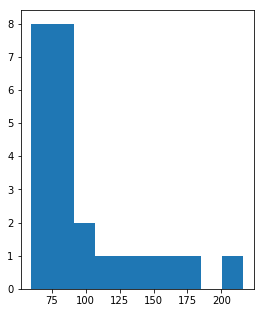

28.503067484662576

In [21]:
a2 = []
for blob in blobs:
    a2.append(len(blobs[blob]))

def trim_areas(area_list):
    new = []
    for area in area_list:
        if (area < (median(area_list) * 10)) and (area > (median(area_list) / 4)):
            new.append(area)
    return new

a2 = trim_areas(a2)
print(median(a2))
print(len(a2))
print(a2)
plt.hist(a2)
plt.show()
sum(a2) / median(a2)

In [22]:
def count_flies(area_list):
    count = 0
    med = median(area_list)
    for area in area_list:
        add = 0
        if area < 1.5 * med:
            add += 1
        if (area > 1.5 * med) and (area < 2.8 * med):
            add += 2
        if (area > 2.8 * med):
            add += 3
        count += add
#         print(area, add)
    return count

In [23]:
count_flies(area_list)

30

In [24]:
def dbscanit(X):
    eps = 1
    min_samples = 4

    db_model = DBSCAN(eps=eps, min_samples=min_samples)
    db_model.fit(X)
    y_pred = db_model.fit_predict(X)
    return len(set(y_pred))

def thresh_clusters(threshold, image):
    img = threshold_grascale_image(image, threshold)
    X = image_array(img)
    if len(X) > 0:
        return dbscanit(X)
    else:
        return 0

[(0, 0), (10, 0), (20, 0), (30, 0), (40, 1), (50, 1), (60, 1), (70, 8), (80, 18), (90, 27), (100, 36), (110, 30), (120, 29), (130, 30), (140, 33), (150, 30), (160, 27), (170, 32), (180, 36), (190, 14), (200, 2), (210, 1), (220, 1), (230, 1), (240, 1), (250, 1)]


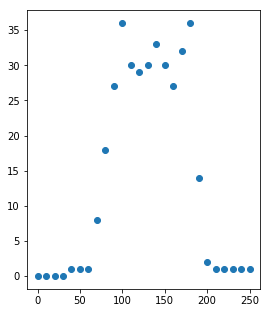

In [25]:
coords = []
for thresh in range(0, 256, 10):
    coords.append((thresh, thresh_clusters(thresh, gray_img)))

print(coords)
plt.scatter([i[0] for i in coords], [i[1] for i in coords])
plt.show()

[(120, 29), (122, 29), (124, 29), (126, 29), (128, 30), (130, 30), (132, 30), (134, 32), (136, 32), (138, 33)]


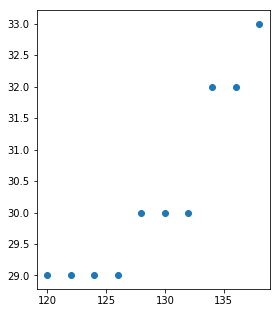

In [26]:
coords = []
for thresh in range(120, 140, 2):
    coords.append((thresh, thresh_clusters(thresh, gray_img)))

print(coords)
plt.scatter([i[0] for i in coords], [i[1] for i in coords])
plt.show()

Cluster number: 33


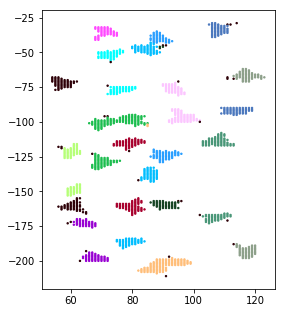

In [27]:
img = threshold_grascale_image(gray_img, 138)
X = image_array(img)

eps = 1
min_samples = 4

db_model = DBSCAN(eps=eps, min_samples=min_samples)
db_model.fit(X)
y_pred = db_model.fit_predict(X)
print("Cluster number: {}".format(len(set(y_pred))))

w,h = img.size
plt.rcParams['figure.figsize'] = (w/50, h/50)
plt.scatter(X[:, 0], X[:, 1], s=2, c=y_pred,  marker="o", cmap=cmap); 
# plt.ylim(90,100)
# plt.xlim(130, 140)
# plt.legend()
plt.show()

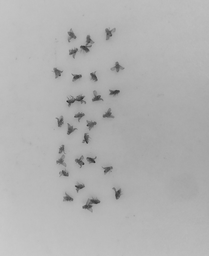

In [28]:
gray_img

In [29]:
def dbscanit(X):
    eps = 1
    min_samples = 2

    db_model = DBSCAN(eps=eps, min_samples=min_samples)
    db_model.fit(X)
    y_pred = db_model.fit_predict(X)
    return X, y_pred
    
# def k_means_it(X):    
    
def count_flies(X, y_pred):    
    # could be new def
    blobs = {}
    for idx, pred in enumerate(y_pred):
        if pred not in blobs:
            blobs[pred] = []
        point = (X[idx][0], X[idx][1])
        blobs[pred].append(point)

    a2 = []
    for blob in blobs:
        a2.append(len(blobs[blob]))
        
    flies = sum(a2) / median(a2)
    return flies

def thresh_clusters(threshold, image):
    img = threshold_grascale_image(image, threshold)
    X = image_array(img)
    if len(X) > 0:
        X, y_pred = dbscanit(X)
        return count_flies(X, y_pred)
    else:
        return 0
    
def trim_areas(area_list):
    new = []
    for area in area_list:
        if (area < (median(area_list) * 10)) and (area > (median(area_list) / 4)):
            new.append(area)
    return new

[(120, 81.42028985507247), (121, 77.97297297297297), (122, 79.09333333333333), (123, 82.21621621621621), (124, 81.42857142857143), (125, 80.275), (126, 80.63414634146342), (127, 78.72093023255815), (128, 78.4090909090909), (129, 77.07692307692308), (130, 76.06382978723404)]


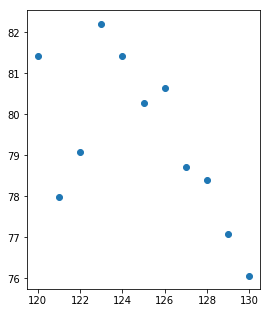

79.39193674122146

In [31]:
# p = 'IMG_clip_20181219_131627.jpg' # 39
# p = 'IMG_clip_20181219_130926.jpg' # 30
# p = 'IMG_clip_20181219_131643.jpg' # 37
p = 'IMG_clip_20181219_131242.jpg' # 73

size = 512, 512

# this rescales in place!
first_img = open_image(img_path)
first_img.thumbnail(size, Image.ANTIALIAS)
gray_img = convert_grayscale(first_img)

coords = []
for thresh in range(120, 131):
    coords.append((thresh, thresh_clusters(thresh, gray_img)))

threshold = [i[0] for i in coords]
flycount = [i[1] for i in coords]

print(coords)
plt.scatter(threshold, flycount)
plt.show()

sum(flycount) / len(flycount)

Cluster number: 75


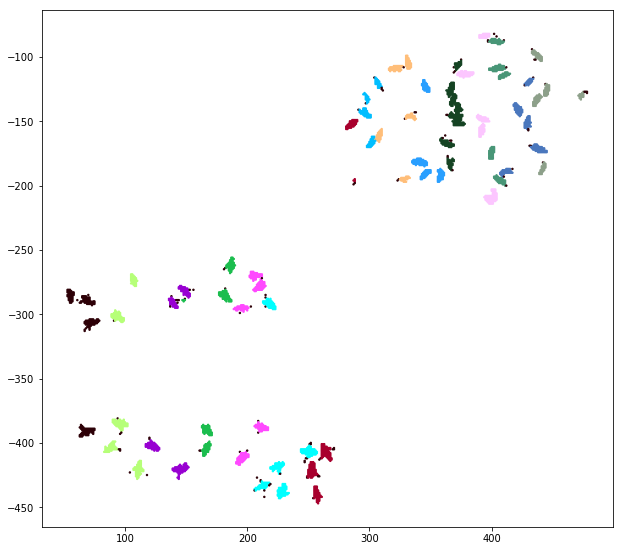

In [58]:
img = threshold_grascale_image(gray_img, 129)
X = image_array(img)

eps = 1
min_samples = 4

db_model = DBSCAN(eps=eps, min_samples=min_samples)
db_model.fit(X)
y_pred = db_model.fit_predict(X)
print("Cluster number: {}".format(len(set(y_pred))))

w,h = img.size
plt.rcParams['figure.figsize'] = (w/50, h/50)
plt.scatter(X[:, 0], X[:, 1], s=2, c=y_pred,  marker="o", cmap=cmap); 
# plt.ylim(90,100)
# plt.xlim(130, 140)
# plt.legend()
plt.show()

Cluster number: 73


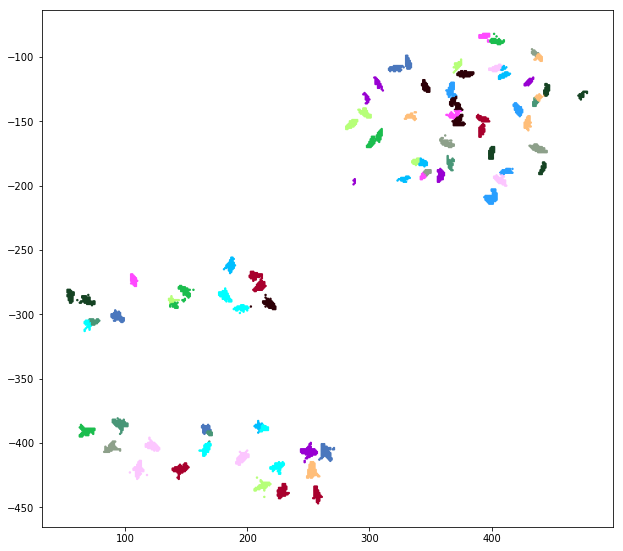

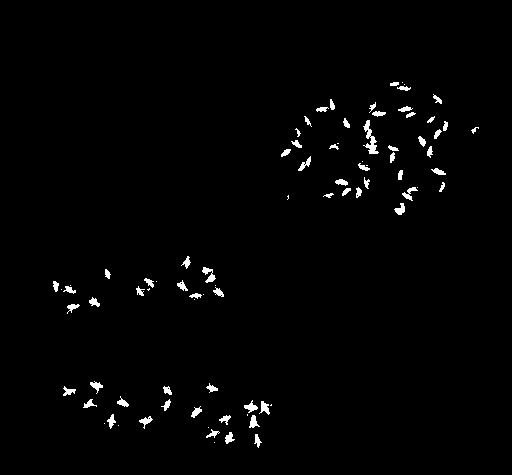

In [60]:
def reduce_point_spread(image, point_list):
    
    # get the size
    width, height = image.size
    
    # create the new image and the pixel iter
    new = create_image(width, height)
    pixels = new.load()
    for i in range(width):
        for j in range(height):
            pixels[i, j] = (0, 0, 0)

                
    # keep if above the value, discard if below
    # black = 0, white is 255
    # if something is not infomative, I want it to be 0.
    # This is because of how I am going to quantify the image
    # later - drop 0's keep the best values
    for point in point_list:
        gray = 255
        i, j = point
        pixels[int(i), int(j)] = (int(gray), int(gray), int(gray))
    
    return new

point_list = []

len(y_pred)

# from DBscan above
for idx, pred in enumerate(y_pred):
    point = (X[idx][0], (X[idx][1] * -1))
    point_list.append(point)

img = reduce_point_spread(gray_img, point_list)

X = image_array(img)

eps = 1
min_samples = 2

kmeans_model = KMeans(n_clusters=73, 
                      n_init=100, 
                      init='random',
                      max_iter=100)
kmeans_model.fit(X)
y_pred = kmeans_model.fit_predict(X)
print("Cluster number: {}".format(len(set(y_pred))))

w,h = img.size
plt.rcParams['figure.figsize'] = (w/50, h/50)
plt.scatter(X[:, 0], X[:, 1], s=2, c=y_pred,  marker="o", cmap=cmap); 
# plt.ylim(90,100)
# plt.xlim(130, 140)
# plt.legend()
plt.show()

Cluster number: 75


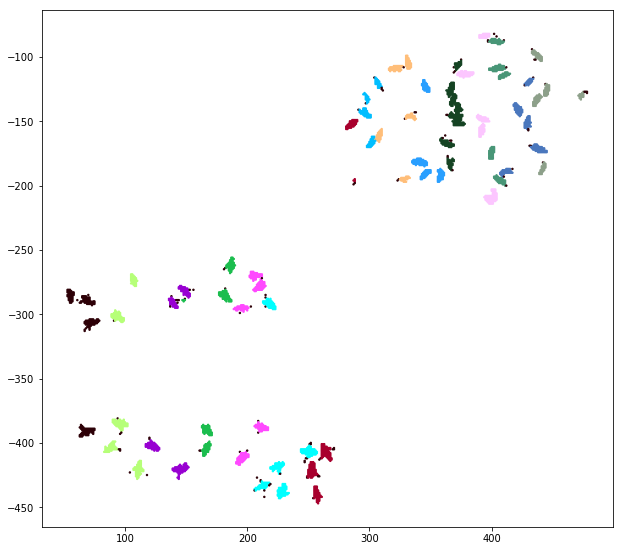

In [64]:
first_img = open_image(img_path)
size = 512, 512
first_img.thumbnail(size, Image.ANTIALIAS)
img = threshold_grascale_image(gray_img, 129)
X = image_array(img)

eps = 1
min_samples = 4

db_model = DBSCAN(eps=eps, min_samples=min_samples)
db_model.fit(X)
y_pred = db_model.fit_predict(X)
print("Cluster number: {}".format(len(set(y_pred))))

w,h = img.size
plt.rcParams['figure.figsize'] = (w/50, h/50)
plt.scatter(X[:, 0], X[:, 1], s=2, c=y_pred,  marker="o", cmap=cmap); 
# plt.ylim(90,100)
# plt.xlim(130, 140)
# plt.legend()
plt.show()

In [76]:
def slice_image(image, points):
    """Grab a rectangular slice of an image based on a list of points"""

    # figure out all the maxes and mins
    xs = [math.sqrt(i[0]*i[0]) for i in points]
    ys = [math.sqrt(i[1]*i[1]) for i in points]
    xmin = int(min(xs))
    xmax = int(max(xs))
    ymin = int(min(ys))
    ymax = int(max(ys))
    width = xmax - xmin + 1
    height = ymax - ymin + 1
    
    # make a new image based on those dimensions
    new = create_image(width, height)
    pixels = new.load()
    
    # map the points of the old image onto the new one
    for point in points:
        x = math.sqrt(point[0] * point[0])
        y = math.sqrt(point[1] * point[1])
        i = x - xmin
        j = y - ymin
        pixel = get_pixel(image, x, y)
        pixels[i, j] = (pixel[0],pixel[1],pixel[2])
    
    return new

In [77]:
## make images slices of all the flies
blobs = {}
for idx, pred in enumerate(y_pred):
    if pred not in blobs:
        blobs[pred] = []
    point = (X[idx][0], X[idx][1])
    blobs[pred].append(point)

blob_ims = {}
for blob in blobs:
    blob_ims[blob] = slice_image(first_img, blobs[blob])

In [103]:
def plot_flies(fly_pics):
    """
    Input: Dictionary of cluster numbers and PIL images of those clusters
    Plots each image
    """
    
    rows = int(len(list(fly_pics.keys())) / 5) + 1
    
    fig, subfigs = plt.subplots(rows, 5, figsize=((3*5), (4*rows)))

    col = 0
    row = 0
    for img in fly_pics:
        
        stitle = str(img)
        subfigs[row, col].imshow(fly_pics[img])
#         subfigs[row, col].set_title(stitle)
        
        if col == 4:
            col = 0
            row += 1
        else:
            col += 1

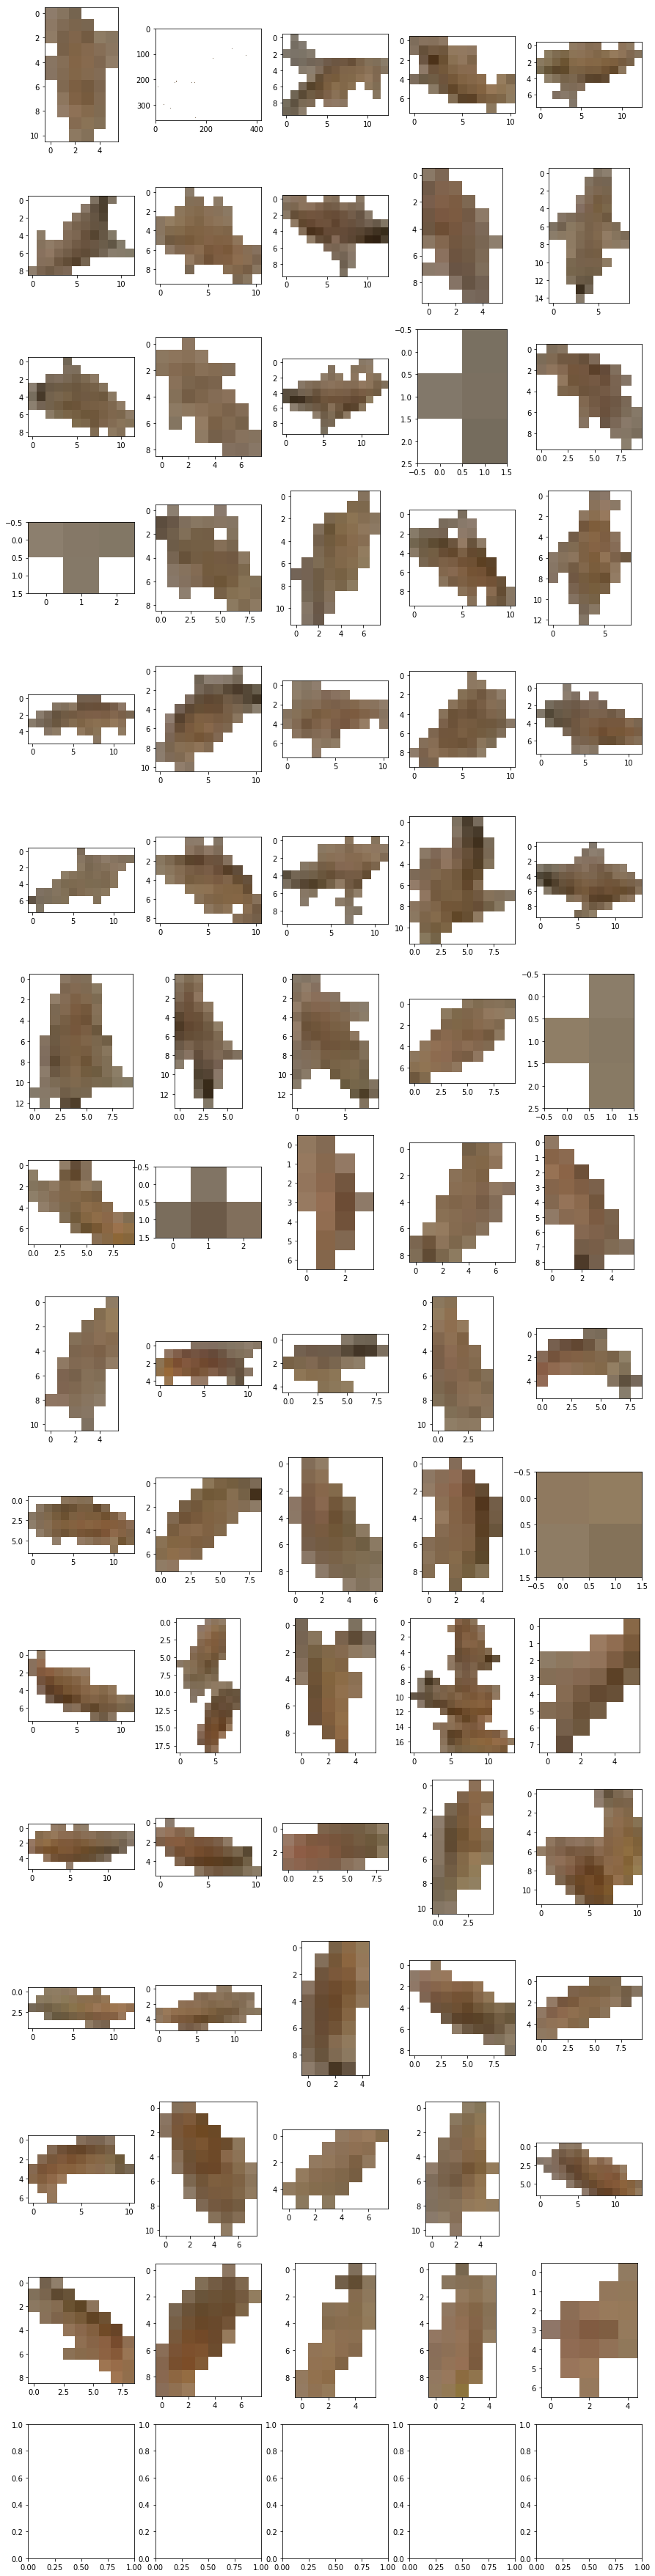

In [104]:
plot_flies(blob_ims)
# plt.imshow(blob_ims[7])